# Bipartite Network Embedding
Seongsik Hwang

Code works fine, but the clustering doesn't seem to perform well.

Tried:
1. Modify the hyperparameters of BiNE
2. Changed embedding/context vector initialization method
    1. Use standard scaler
    2. Use a uniform distribution, with values between 0 and 10
    3. Use a normal distribution, with values between 0 and 10
3. Modify DBSCAN parameters
4. Perform operations on larger datasets

In [1]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import sklearn
import random
import math
import itertools
from datasketch import MinHash, MinHashLSH

In [2]:
# args
data_path = 'sample_bipartite_network.txt'
ws = 5 # 5
ns = 4 # 4
d_vector = 16
maxT = 4
minT = 1
p_stop = 0.15

alpha = 0.01
beta = 0.01
gamma = 0.1

lam = 0.01 # learning_rate

# 1. Take the input

In [3]:
# Read graph
def readEdgeList(fileName):
    #print(fileName)
    g1 = bipartite.read_edgelist(fileName)
    print("V=", g1.number_of_nodes(), "\tE=", g1.number_of_edges())
    return g1

G = readEdgeList(data_path)
G.remove_edges_from(nx.selfloop_edges(G))

V= 17 	E= 24


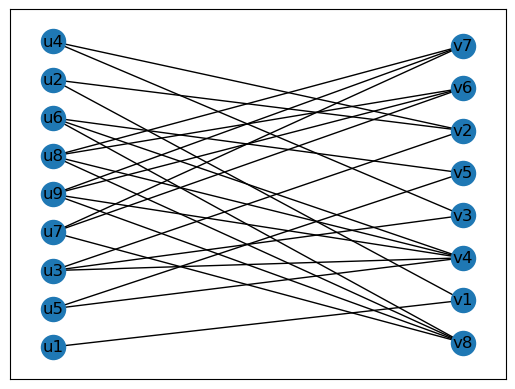

In [4]:
# Plot the graph
def bipartite_layout(inputG):
    if nx.is_bipartite(inputG) and nx.is_connected(inputG):## connected and bipartite
        bs1, bs2 = nx.bipartite.sets(inputG)
        pos = {}
        pos.update({n:(0, 1.0/(len(bs1)+1)*(i+1)) for i, n in enumerate(bs1)})
        pos.update({n:(1, 1.0/(len(bs2)+1)*(i+1)) for i, n in enumerate(bs2)})
        return pos
    else:
        print("it is not bipartite and not connected")

nx.draw_networkx(G, pos=bipartite_layout(G))

## Initialize necessary values

In [5]:
# 1. node_u, node_v
if 'u' in list(bipartite.sets(G)[0])[0]:
    node_u = list(bipartite.sets(G)[0])
    node_v = list(bipartite.sets(G)[1])
    
else:
    node_u = list(bipartite.sets(G)[1])
    node_v = list(bipartite.sets(G)[0])

node_u.sort()
node_v.sort()

print("node_u:", node_u)
print("node_v:", node_v)

node_u: ['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9']
node_v: ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8']


In [6]:
# 2. edge_list
edge_list = list(nx.edges(G))
print(edge_list)

[('u1', 'v1'), ('v1', 'u2'), ('u2', 'v2'), ('v2', 'u3'), ('v2', 'u4'), ('u3', 'v3'), ('u3', 'v4'), ('v3', 'u4'), ('v4', 'u5'), ('v4', 'u6'), ('v4', 'u8'), ('v4', 'u9'), ('u5', 'v5'), ('v5', 'u6'), ('u6', 'v8'), ('v8', 'u7'), ('v8', 'u8'), ('v8', 'u9'), ('u7', 'v6'), ('u7', 'v7'), ('v6', 'u8'), ('v6', 'u9'), ('v7', 'u8'), ('v7', 'u9')]


In [7]:
# 3. edge_list for each nodes
edge_list_u, edge_list_v = {}, {}

for i in node_u:
    nodes_in_v = []
    for j in edge_list:
        if i in j:
            if i == j[0]:
                nodes_in_v.append(j[1])
            else:
                nodes_in_v.append(j[0])
    edge_list_u[i] = nodes_in_v
for i in node_v:
    nodes_in_u = []
    for j in edge_list:
        if i in j:
            if i == j[0]:
                nodes_in_u.append(j[1])
            else:
                nodes_in_u.append(j[0])
    edge_list_v[i] = nodes_in_u
print('edge_list_u:',edge_list_u, '\nedge_list_v:', edge_list_v)

edge_list_u: {'u1': ['v1'], 'u2': ['v1', 'v2'], 'u3': ['v2', 'v3', 'v4'], 'u4': ['v2', 'v3'], 'u5': ['v4', 'v5'], 'u6': ['v4', 'v5', 'v8'], 'u7': ['v8', 'v6', 'v7'], 'u8': ['v4', 'v8', 'v6', 'v7'], 'u9': ['v4', 'v8', 'v6', 'v7']} 
edge_list_v: {'v1': ['u1', 'u2'], 'v2': ['u2', 'u3', 'u4'], 'v3': ['u3', 'u4'], 'v4': ['u3', 'u5', 'u6', 'u8', 'u9'], 'v5': ['u5', 'u6'], 'v6': ['u7', 'u8', 'u9'], 'v7': ['u7', 'u8', 'u9'], 'v8': ['u6', 'u7', 'u8', 'u9']}


# 2. Initialize embedding&context vectors

In [8]:
node_list_u, node_list_v = {}, {}

In [9]:
from sklearn import preprocessing

# Create random vectors

for i in node_u:
    vectors = np.random.random([1, d_vector])
    help_vectors = np.random.random([1, d_vector])
    node_list_u[i] = {}
    node_list_u[i]['embedding_vectors'] = preprocessing.normalize(vectors, norm='l2')[0]
    node_list_u[i]['context_vectors'] = preprocessing.normalize(help_vectors, norm='l2')[0]
for i in node_v:
    vectors = np.random.random([1, d_vector])
    help_vectors = np.random.random([1, d_vector])
    node_list_v[i] = {}
    node_list_v[i]['embedding_vectors'] = preprocessing.normalize(vectors, norm='l2')[0]
    node_list_v[i]['context_vectors'] = preprocessing.normalize(help_vectors, norm='l2')[0]

# for i in node_u:
#     node_list_u[i] = {}
#     node_list_u[i]['embedding_vectors'] = np.random.uniform(0, 10, d_vector)
#     node_list_u[i]['context_vectors'] = np.random.uniform(0, 10, d_vector)
# for i in node_v:
#     node_list_v[i] = {}
#     node_list_v[i]['embedding_vectors'] = np.random.uniform(0, 10, d_vector)
#     node_list_v[i]['context_vectors'] = np.random.uniform(0, 10, d_vector)

# for i in node_u:
#     node_list_u[i] = {}
#     node_list_u[i]['embedding_vectors'] = np.random.normal(5, 2.5, d_vector)
#     node_list_u[i]['embedding_vectors'] = np.clip(node_list_u[i]['embedding_vectors'], 0, 10)
#     node_list_u[i]['context_vectors'] = np.random.normal(5, 2.5, d_vector)
#     node_list_u[i]['context_vectors'] = np.clip(node_list_u[i]['context_vectors'], 0, 10)
# for i in node_v:
#     node_list_v[i] = {}
#     node_list_v[i]['embedding_vectors'] = np.random.normal(5, 2.5, d_vector)
#     node_list_v[i]['embedding_vectors'] = np.clip(node_list_v[i]['embedding_vectors'], 0, 10)
#     node_list_v[i]['context_vectors'] = np.random.normal(5, 2.5, d_vector)
#     node_list_v[i]['context_vectors'] = np.clip(node_list_v[i]['context_vectors'], 0, 10)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# vec = []
# for i in node_u:
#     vectors = np.random.random([1, d_vector])
#     help_vectors = np.random.random([1, d_vector])
#     node_list_u[i] = {}
#     vec.append(vectors[0])
#     vec.append(help_vectors[0])
#     node_list_u[i]['embedding_vectors'] = vectors
#     node_list_u[i]['context_vectors'] = help_vectors
    
# for i in node_v:
#     vectors = np.random.random([1, d_vector])
#     help_vectors = np.random.random([1, d_vector])
#     scaler.fit(vectors)
#     node_list_v[i] = {}
#     vec.append(vectors[0])
#     vec.append(help_vectors[0])
#     node_list_v[i]['embedding_vectors'] = vectors
#     node_list_v[i]['context_vectors'] = help_vectors

# scaler.fit(vec)
# for i in node_u:
#     node_list_u[i]['embedding_vectors'] = scaler.transform(node_list_u[i]['embedding_vectors'])[0]
#     node_list_u[i]['context_vectors'] = scaler.transform(node_list_u[i]['context_vectors'])[0]
# for i in node_v:
#     node_list_v[i]['embedding_vectors'] = scaler.transform(node_list_v[i]['embedding_vectors'])[0]
#     node_list_v[i]['context_vectors'] = scaler.transform(node_list_v[i]['context_vectors'])[0]

# 3. Pre-training embedding vectors

In [10]:
# reference of code: https://github.com/clhchtcjj/BiNE
def KL_divergence(u, v, node_list_u, node_list_v, lam, gamma):
    loss = 0
    weight = 1 # In this project, any weight of bipartite graph is always 1.

    update_u = 0
    update_v = 0
    U = np.array(node_list_u[u]['embedding_vectors'])
    V = np.array(node_list_v[v]['embedding_vectors'])
    X = float(U.dot(V.T))

    sigmod = 1.0 / (1 + (math.exp(-X * 1.0)))

    update_u += gamma * lam * ((weight * (1 - sigmod)) * 1.0 / math.log(math.e, math.e)) * V
    update_v += gamma * lam * ((weight * (1 - sigmod)) * 1.0 / math.log(math.e, math.e)) * U

    try:
        loss += gamma * weight * math.log(sigmod)
    except:
        pass
        # print "KL:",
        # print(U,V,sigmod,X,math.exp(-X * 1.0),round(math.exp(-X * 1.0),10))
    return update_u, update_v, loss

In [11]:
# Pre-train the embedding vectors
for i in edge_list:
    if 'u' in i[0]:
        u = i[0]
        v = i[1]
    else:
        u = i[1]
        v = i[0]
    
    updated_u, updated_v, _ = KL_divergence(u, v, node_list_u, node_list_v, lam, gamma)
    node_list_u[u]['embedding_vectors'], node_list_v[v]['embedding_vectors'] = updated_u, updated_v

# 4. Create corpus using walk-generator

In [12]:
def save_homogenous_graph_to_file(A, datafile, index_row, index_item):
    (M,N) = A.shape
    csr_dict = A.__dict__
    data = csr_dict.get("data")
    indptr = csr_dict.get("indptr")
    indices = csr_dict.get("indices")
    col_index = 0
    with open(datafile,'w') as fw:
        for row in range(M):
            for col in range(indptr[row],indptr[row+1]):
                r = row
                c = indices[col]
                fw.write(index_row.get(r)+"\t"+index_item.get(c)+"\n") #+"\t"+str(data[col_index])+"\n")
                col_index += 1
                
def random_walk(G, nodes, percentage, rand=random.Random(), start=None):
    """ Returns a truncated random walk.
        percentage: probability of stopping walking
        start: the start node of the random walk.
    """
    if start:
        path = [start]
    else:
        # Sampling is uniform w.r.t V, and not w.r.t E
        path = [rand.choice(nodes)]

    while len(path) < 1 or random.random() > percentage:
        cur = path[-1]
        if len(G[cur]) > 0:
            if rand.random() >= 0:
                add_node = rand.choice(list(G[cur].keys()))
                while add_node == cur:
                    add_node = rand.choice(list(G[cur].keys()))
                path.append(add_node)
            else:
                path.append(path[0])
        else:
            break
    return path

def build_deepwalk_corpus_random(G, hits_dict, percentage, maxT, minT, rand = random.Random()):
    walks = []
    nodes = list(G.nodes())
    for node in nodes:
        num_paths = max(int(math.ceil(maxT * hits_dict[node])),minT)
        for cnt in range(num_paths):
            walks.append(random_walk(G, nodes, percentage, rand=rand, start=node))
    random.shuffle(walks)
    return walks

In [13]:
# I performed walk generator on node_u and node_v simultaneously.
def walk_generator(G, node_u, node_v, maxT, minT, p, edge_list):
    # calculate every vertices' centrality
    h, a = nx.hits(G)
    corpus_list_u = []
    corpus_list_v = []
    
    # create homogeneous graph for nodes u and nodes v
    A = bipartite.biadjacency_matrix(G, node_u, node_v, dtype=float,weight='weight', format='csr')
    row_index = dict(zip(node_u, itertools.count()))
    col_index = dict(zip(node_v, itertools.count()))
    index_row = dict(zip(row_index.values(), row_index.keys()))
    index_item = dict(zip(col_index.values(), col_index.keys()))
    AT = A.transpose()
    
    save_homogenous_graph_to_file(A.dot(AT), 'bine_u_homogeneous', index_row, index_row)
    save_homogenous_graph_to_file(AT.dot(A), 'bine_v_homogeneous', index_item, index_item)
    
    G_homogeneous_u = nx.read_edgelist('bine_u_homogeneous')
    G_homogeneous_v = nx.read_edgelist('bine_v_homogeneous')
    
    for i in node_u:
        l = max(a[i] * maxT, minT)
        for j in range(0, int(l)):
            #Perform biased-random walks
            walks = build_deepwalk_corpus_random(G_homogeneous_u, a, percentage=p, maxT = maxT, minT = minT)
            corpus_list_u += walks
    
    for i in node_v:
        l = max(a[i] * maxT, minT)
        for j in range(0, int(l)):
            #Perform biased-random walks
            walks = build_deepwalk_corpus_random(G_homogeneous_v, a, percentage=p, maxT = maxT, minT = minT)
            corpus_list_v += walks
    return (corpus_list_u, corpus_list_v)

In [14]:
# Generate corpus for node_u and node_v
d_u, d_v = [], []
d_u, d_v = walk_generator(G, node_u, node_v, maxT, minT, p_stop, edge_list)

/Users/hwangseongsik/opt/anaconda3/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
/var/folders/6v/yhx3gh1534dd0486tkvm786m0000gn/T/ipykernel_67037/27684214.py:9: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  A = bipartite.biadjacency_matrix(G, node_u, node_v, dtype=float,weight='weight', format='csr')


# 5. Training
$$maximize L = α \log O_2 + β \log O_3 − γO_1$$

To optimize this objective, we use **SGA(Stochastic Gradient Ascent)**.
1. Update $\vec u_i$ and $\vec v_j$ utilizing last component $L_1 = -\gamma O_1$
2. Update $\vec u_i$ and $\vec\theta_i$ utilizing first component $L_2 = \alpha \log O_2$
3. Update $\vec v_j$ and $\vec\vartheta_j$ utilizing second component $L_3=\beta \log O_3$

In [15]:
# Helper functions for doing negative sampling by lsh
def construct_lsh(obj_dict):
    lsh_0 = MinHashLSH(threshold=0, num_perm=128,params=None)
    lsh_5 = MinHashLSH(threshold=0.6, num_perm=128,params=None)
    # forest = MinHashLSHForest(num_perm=128)
    keys = list(obj_dict.keys())
    values = list(obj_dict.values())
    ms = []
    for i in range(len(keys)):
        temp = MinHash(num_perm=128)
        for d in values[i]:
            temp.update(d.encode('utf8'))
        ms.append(temp)
        lsh_0.insert(keys[i], temp)
        lsh_5.insert(keys[i], temp)
    return lsh_0,lsh_5, keys, ms

def call_get_negs_by_lsh(sample_num, obj_dict):
    lsh_0,lsh_5, keys, ms = construct_lsh(obj_dict)
    visited = []
    negs_dict = {}
    for i in range(len(keys)):
        record = []
        if i in visited:
            continue
        visited.append(i)
        record.append(i)
        total_list = set(keys)
        sim_list = set(lsh_0.query(ms[i]))
        high_sim_list = set(lsh_5.query(ms[i]))
        total_list = list(total_list - sim_list)
        for j in high_sim_list:
            total_list = set(total_list)
            ind = keys.index(j)
            if ind not in visited:
                visited.append(ind)
                record.append(ind)
            sim_list_child = set(lsh_0.query(ms[ind]))
            total_list = list(total_list - sim_list_child)
        total_list = random.sample(list(total_list), min(sample_num, len(total_list)))
        for j in record:
            key = keys[j]
            negs_dict[key] = total_list
    return negs_dict

In [16]:
def get_negs_by_lsh(user_dict, item_dict, num_negs):
    sample_num_u = max(300, int(len(user_dict)*0.01*num_negs))
    sample_num_v = max(300, int(len(item_dict)*0.01*num_negs))
    negs_u = call_get_negs_by_lsh(sample_num_u,user_dict)
    negs_v = call_get_negs_by_lsh(sample_num_v,item_dict)
    return negs_u,negs_v

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def indicator(z, context):
    if z in context:
        return 1
    else:
        return 0

visited_u = dict(zip(node_list_u, [0] * len(node_list_u)))
visited_v = dict(zip(node_list_v, [0] * len(node_list_v)))

# Start traning
for i in edge_list:
    if 'u' in i[0]:
        u = i[0]
        v = i[1]
    else:
        u = i[1]
        v = i[0]
        
    # 1. Update embedding vectors using explicit relation
    node_list_u[u]['embedding_vectors'] = node_list_u[u]['embedding_vectors'] + lam * gamma * (1-sigmoid(np.dot(node_list_u[u]['embedding_vectors'], node_list_v[v]['embedding_vectors']))) * node_list_v[v]['embedding_vectors']
    
    node_list_v[v]['embedding_vectors'] = node_list_v[v]['embedding_vectors'] + lam * gamma * (1-sigmoid(np.dot(node_list_v[v]['embedding_vectors'], node_list_u[u]['embedding_vectors']))) * node_list_u[u]['embedding_vectors']
    
    # negative sampling
    neg_u, neg_v = get_negs_by_lsh(edge_list_u, edge_list_v, ns)
    
    # 2. Update embedding vectors using implicit relation
    for j in d_u:
        if u not in j:
            continue
        for k in j:
            # k is context vertex, j is context vertices list.
            for l in neg_u: # I'm not entirely sure about this part.
                node_list_u[u]['embedding_vectors'] = node_list_u[u]['embedding_vectors'] + lam * alpha * (indicator(l,j)-sigmoid(np.dot(node_list_u[u]['embedding_vectors'],node_list_u[l]['context_vectors']))) * node_list_u[l]['context_vectors']
                node_list_u[l]['context_vectors'] = node_list_u[l]['context_vectors'] + lam * alpha * (indicator(l,j)-sigmoid(np.dot(node_list_u[u]['embedding_vectors'],node_list_u[l]['context_vectors']))) * node_list_u[u]['embedding_vectors']
        
    for j in d_v:
        if v not in j:
            continue
        for k in j:
            # k is context vertex, j is context vertices list.
            for l in neg_v: # I'm not entirely sure about this part.
                node_list_v[v]['embedding_vectors'] = node_list_v[v]['embedding_vectors'] + lam * alpha * (indicator(l,j)-sigmoid(np.dot(node_list_v[v]['embedding_vectors'],node_list_v[l]['context_vectors']))) * node_list_v[l]['context_vectors']
                node_list_v[l]['context_vectors'] = node_list_v[l]['context_vectors'] + lam * alpha * (indicator(l,j)-sigmoid(np.dot(node_list_v[v]['embedding_vectors'],node_list_v[l]['context_vectors']))) * node_list_v[v]['embedding_vectors']
                
print(node_list_u)

{'u1': {'embedding_vectors': array([0.00430731, 0.00866268, 0.00888315, 0.00286268, 0.0072558 ,
       0.00594401, 0.00743436, 0.00779861, 0.00922091, 0.00629801,
       0.00602364, 0.00564833, 0.00455369, 0.00485564, 0.00678423,
       0.00537403]), 'context_vectors': array([0.0281373 , 0.28459357, 0.41107762, 0.12023494, 0.02246686,
       0.12057268, 0.37277654, 0.36174158, 0.26314707, 0.32887716,
       0.31806984, 0.13416731, 0.14978398, 0.23521135, 0.22061317,
       0.1310422 ])}, 'u2': {'embedding_vectors': array([0.00997238, 0.01775795, 0.01720529, 0.00463585, 0.01789252,
       0.01298643, 0.0145018 , 0.01509926, 0.02003816, 0.01139509,
       0.01099329, 0.01261878, 0.01013854, 0.00803886, 0.01400281,
       0.01155505]), 'context_vectors': array([0.14660851, 0.29111719, 0.28082991, 0.08459786, 0.58188872,
       0.16880045, 0.34667625, 0.24697528, 0.36237888, 0.10789104,
       0.00703129, 0.09659179, 0.09249236, 0.02491653, 0.11493537,
       0.28542438])}, 'u3': {'embeddi

In [18]:
# start dbscan on args.vector_u, args.vector_v
from sklearn.cluster import DBSCAN

X_lst = []
for u in node_list_u.keys():
    X_lst.append(node_list_u[u]['embedding_vectors'].tolist())
for v in node_list_v.keys():
    X_lst.append(node_list_v[v]['embedding_vectors'].tolist())
X = np.array(X_lst) # [u1, u2, ..., v1, v2, ...]

clustering = DBSCAN(eps=3, min_samples=2).fit(X)

print(clustering.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
